# GEOG606 - Final Project
#### Zachary Burnett 2022-04-12

In [2944]:
from datetime import datetime
from pathlib import Path

import numpy
import pandas
from stormevents import StormEvent
import geopandas
import xarray
from geopandas import GeoDataFrame, GeoSeries
from matplotlib import pyplot
from cartopy import crs
from stormevents.coops import COOPS_Station, coops_stations

In [2945]:
data_directory = Path() / 'data'

#### retrieve NaturalEarth country boundaries

In [2946]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

## NOAA CO-OPS water level stations

In [2947]:
stations = coops_stations(station_status='active')
stations

,nws_id,name,state,status,removed,geometry
nos_id,,,,,,
1600012,46125,QREB buoy,,active,<NA>,POINT (122.62500 37.75000)
1619910,SNDP5,"Sand Island, Midway Islands",,active,<NA>,POINT (-177.37500 28.21875)
1630000,APRP7,"Apra Harbor, Guam",,active,<NA>,POINT (144.62500 13.44531)
1631428,PGBP7,"Pago Bay, Guam",,active,<NA>,POINT (144.75000 13.42969)
1770000,NSTP6,"Pago Pago, American Samoa",,active,<NA>,POINT (-170.75000 -14.27344)
...,...,...,...,...,...,...
8729840,PCLF1,Pensacola,FL,active,"2022-04-01 10:00:00,2022-04-01 00:00:00,2020-0...",POINT (-87.18750 30.40625)
8775132,LQAT2,La Quinta Channel North,TX,active,"2022-04-04 00:00:00,2022-02-18 00:00:00,2022-0...",POINT (-97.25000 27.87500)
8735180,DILA1,Dauphin Island,AL,active,"2022-04-11 23:58:00,2019-07-18 10:00:00,2018-0...",POINT (-88.06250 30.25000)


Text(0.5, 1.0, 'active NOAA CO-OPS sensor stations as of 2022-05-03')

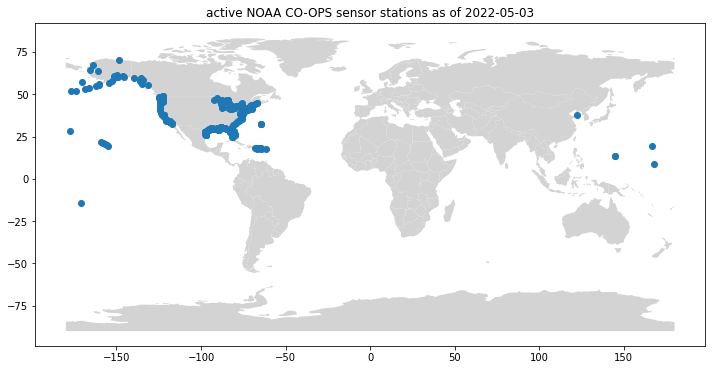

In [2948]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
stations.plot(ax=axis)

axis.set_title(f'active NOAA CO-OPS sensor stations as of {datetime.now():%Y-%m-%d}')

## Hurricane Florence (2018)

In [2949]:
storm = StormEvent('florence', 2018)
storm

StormEvent(name='FLORENCE', year=2018, start_date=Timestamp('2018-08-30 06:00:00'), end_date=Timestamp('2018-09-18 12:00:00'))

In [2950]:
best_track = storm.track(advisories=['BEST'])
best_track

/home/zrb/environments/GEOG606/lib/python3.10/site-packages/pandas/core/indexing.py:2115: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)
/home/zrb/environments/GEOG606/lib/python3.10/site-packages/pandas/core/indexing.py:2115: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  new_ix = Index(new_ix)


VortexTrack('AL062018', Timestamp('2018-08-30 06:00:00'), Timestamp('2018-09-18 12:00:00'), <ATCF_FileDeck.BEST: 'b'>, [<ATCF_Advisory.BEST: 'BEST'>], None)

In [2951]:
track_bounds = numpy.stack([
    best_track.data[['longitude', 'latitude']].min().values,
    best_track.data[['longitude', 'latitude']].max().values,
], axis=1)
track_bounds[:, 0] -= 1
track_bounds[:, 1] += 1

In [2952]:
wind_swath_34kt = best_track.wind_swaths(wind_speed=34)['BEST']['20180830T060000']

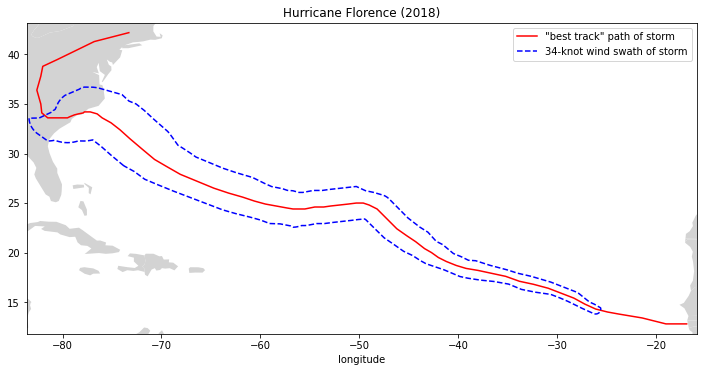

In [2953]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
axis.set_xlim(*track_bounds[0, :])
axis.set_ylim(*track_bounds[1, :])

best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')

axis.set_title('Hurricane Florence (2018)')
axis.legend()

### load water level data modeled by the ADCIRC oceanic circulation model during Hurricane Florence (2018) within a 34-knot wind swath of the storm's path

In [2954]:
filename = data_directory / 'run_20220502_florence2018_coopsstations' / 'runs' / 'unperturbed' / 'fort.61.nc'
modeled_water_levels = xarray.open_dataset(filename, drop_variables=['neta', 'nvel', 'max_nvdll', 'max_nvell'])
modeled_water_levels['station_name'] = modeled_water_levels['station_name'].astype(str).astype(int)
modeled_water_levels

<xarray.Dataset>
Dimensions:       (time: 1440, station: 164)
Coordinates:
  * time          (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06...
Dimensions without coordinates: station
Data variables:
    station_name  (station) int64 8726412 8726679 8726694 ... 8423898 8726667
    x             (station) float64 ...
    y             (station) float64 ...
    zeta          (time, station) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            v55.00-75-gd31ac36
    grid_type:          Triangular
    description:        created on 2022-05-03 01:59                          ...
    ...                 ...
    sfea0:              30.284679
    cf:                 0.0025
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               15

In [2955]:
modeled_water_levels = modeled_water_levels.rename({
    'station_name': 'nos_id',
})
modeled_water_levels = modeled_water_levels.assign_coords({
    'station': modeled_water_levels['nos_id'],
    'x': modeled_water_levels['x'],
    'y': modeled_water_levels['y'],
})
modeled_water_levels = modeled_water_levels.drop(['nos_id'])
modeled_water_levels = modeled_water_levels.rename({
    'station': 'nos_id',
})
modeled_water_levels = modeled_water_levels.sortby('nos_id')
modeled_water_levels

<xarray.Dataset>
Dimensions:  (time: 1440, nos_id: 164)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
    x        (nos_id) float64 -75.5 -75.94 -67.0 -67.19 ... -82.62 -83.88 -83.31
    y        (nos_id) float64 44.69 44.34 44.91 44.66 ... 43.84 43.62 44.66
  * nos_id   (nos_id) int64 8311030 8311062 8410140 ... 9075014 9075035 9075059
Data variables:
    zeta     (time, nos_id) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            v55.00-75-gd31ac36
    grid_type:          Triangular
    description:        created on 2022-05-03 01:59                          ...
    ...                 ...
    sfea0:              30.284679
    cf:                 0.0025
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               15

In [2956]:
modeled_water_levels['zeta']

<xarray.DataArray 'zeta' (time: 1440, nos_id: 164)>
[236160 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
    x        (nos_id) float64 -75.5 -75.94 -67.0 -67.19 ... -82.62 -83.88 -83.31
    y        (nos_id) float64 44.69 44.34 44.91 44.66 ... 43.84 43.62 44.66
  * nos_id   (nos_id) int64 8311030 8311062 8410140 ... 9075014 9075035 9075059
Attributes:
    long_name:      water surface elevation above geoid
    standard_name:  sea_surface_height_above_geoid
    units:          m

In [2957]:
stations_bounds = numpy.array([
    [modeled_water_levels['x'].min(), modeled_water_levels['x'].max()],
    [modeled_water_levels['y'].min(), modeled_water_levels['y'].max()],
])
stations_bounds[:, 0] -= 1
stations_bounds[:, 1] += 1
stations_bounds

array([[-84.875   , -66.      ],
       [ 24.734375,  45.90625 ]])

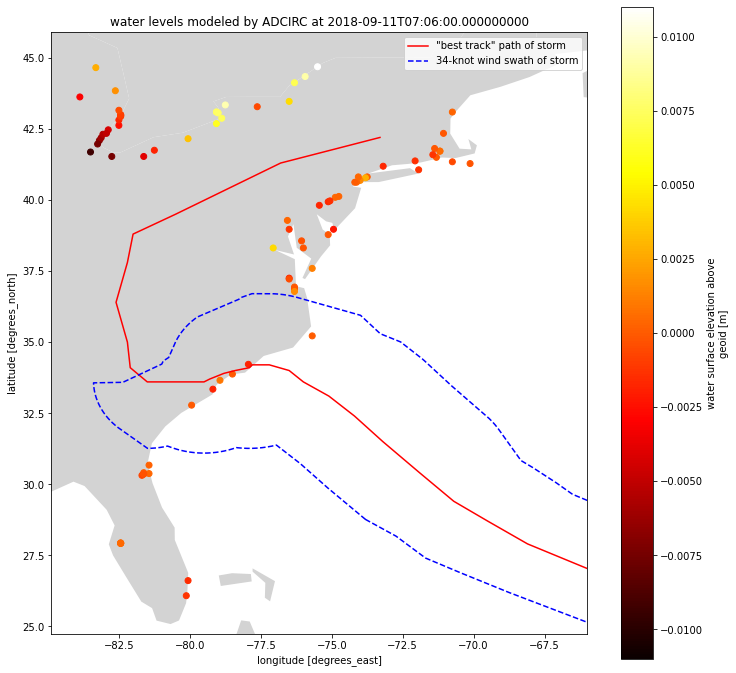

In [2958]:
figure = pyplot.figure(figsize=(12, 12))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

modeled_water_levels_at_selected_time = modeled_water_levels.isel(time=10)
modeled_water_levels_at_selected_time.plot.scatter(x='x', y='y', hue='zeta', cmap='hot', ax=axis)

axis.set_title(f'water levels modeled by ADCIRC at {modeled_water_levels_at_selected_time["time"].values}')
axis.legend()

### retrieve water level data observed by NOAA CO-OPS during Hurricane Florence (2018) within the 34-knot isotach of the storm

In [2959]:
observed_water_levels_filename = data_directory / 'florence2018_east_coast_water_levels.nc'

if not observed_water_levels_filename.exists():
    stations = [
        COOPS_Station(float(nos_id.values))
        for nos_id in modeled_water_levels['nos_id']
    ]
    data = []
    for station in stations:
        station_data = station.product(
            'water_level',
            start_date=pandas.to_datetime(min(modeled_water_levels['time']).values),
            end_date=pandas.to_datetime(max(modeled_water_levels['time']).values),
            units='metric',
        )
        if numpy.product(list(station_data.sizes.values())) > 0:
            data.append(station_data)
        else:
            print(f'no data at {station}')
    observed_water_levels = xarray.combine_by_coords(data)
    observed_water_levels.to_netcdf(observed_water_levels_filename)
else:
    observed_water_levels = xarray.open_dataset(observed_water_levels_filename)

observed_water_levels = observed_water_levels.rename({'t': 'time'})
observed_water_levels['v'] /= 100
observed_water_levels['s'] /= 100

observed_water_levels = observed_water_levels.sortby('nos_id')

observed_water_levels

<xarray.Dataset>
Dimensions:  (time: 1440, nos_id: 111)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
  * nos_id   (nos_id) int64 8311030 8311062 8410140 ... 9075002 9075014 9075035
    nws_id   (nos_id) object ...
    x        (nos_id) float64 ...
    y        (nos_id) float64 ...
Data variables:
    v        (nos_id, time) float32 0.7427 0.7427 0.7427 ... 1.769 1.769 1.769
    s        (nos_id, time) float32 1e-05 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    f        (nos_id, time) object ...
    q        (nos_id, time) object ...

In [2960]:
observed_water_levels['v']

<xarray.DataArray 'v' (nos_id: 111, time: 1440)>
array([[0.7427    , 0.74267995, 0.74267   , ..., 0.74274004, 0.74273   ,
        0.74274004],
       [0.74541   , 0.74542   , 0.74544   , ..., 0.74524003, 0.74523   ,
        0.74527   ],
       [0.06736   , 0.06604   , 0.0647    , ..., 0.03643   , 0.03762   ,
        0.03877   ],
       ...,
       [1.7694    , 1.76951   , 1.76966   , ..., 1.76923   , 1.76908   ,
        1.7690899 ],
       [1.76933   , 1.76925   , 1.76934   , ..., 1.7690899 , 1.76932   ,
        1.76929   ],
       [1.76996   , 1.7699499 , 1.76996   , ..., 1.7692399 , 1.7692101 ,
        1.76916   ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
  * nos_id   (nos_id) int64 8311030 8311062 8410140 ... 9075002 9075014 9075035
    nws_id   (nos_id) object 'OBGN6' 'ALXN6' 'PSBM1' ... 'LKPM4' 'HRBM4' 'ESVM4'
    x        (nos_id) float64 -75.5 -75.94 -67.0 -67.19 ... -82.5 -82.62 -83.88
    y        (nos_id) float64 44.69 44.34 44.91 44.66 ... 43.16 43.84 43.62

### normalize observed water levels by subtracting the time average for each station

In [2961]:
observed_water_levels['normalized_v'] = observed_water_levels['v'] - observed_water_levels['v'].mean(dim='time')
observed_water_levels['normalized_v']

<xarray.DataArray 'normalized_v' (nos_id: 111, time: 1440)>
array([[-1.9383430e-04, -2.1386147e-04, -2.2381544e-04, ...,
        -1.5377998e-04, -1.6379356e-04, -1.5377998e-04],
       [ 1.2898445e-04,  1.3893843e-04,  1.5896559e-04, ...,
        -4.1007996e-05, -5.1021576e-05, -1.1026859e-05],
       [ 2.3347914e-02,  2.2027917e-02,  2.0687915e-02, ...,
        -7.5820871e-03, -6.3920841e-03, -5.2420832e-03],
       ...,
       [-1.1432171e-04, -4.2915344e-06,  1.4567375e-04, ...,
        -2.8431416e-04, -4.3427944e-04, -4.2438507e-04],
       [-5.9247017e-05, -1.3923645e-04, -4.9233437e-05, ...,
        -2.9933453e-04, -6.9260597e-05, -9.9301338e-05],
       [ 1.5783310e-04,  1.4770031e-04,  1.5783310e-04, ...,
        -5.6231022e-04, -5.9211254e-04, -6.4218044e-04]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T06:06:00 ... 2018-09-17T06:00:00
  * nos_id   (nos_id) int64 8311030 8311062 8410140 ... 9075002 9075014 9075035
    nws_id   (nos_id) object 'OBGN6' 'ALXN6' 'PSBM1' ... 'LKPM4' 'HRBM4' 'ESVM4'
    x        (nos_id) float64 -75.5 -75.94 -67.0 -67.19 ... -82.5 -82.62 -83.88
    y        (nos_id) float64 44.69 44.34 44.91 44.66 ... 43.16 43.84 43.62

### compare modeled water levels vs observed water levels

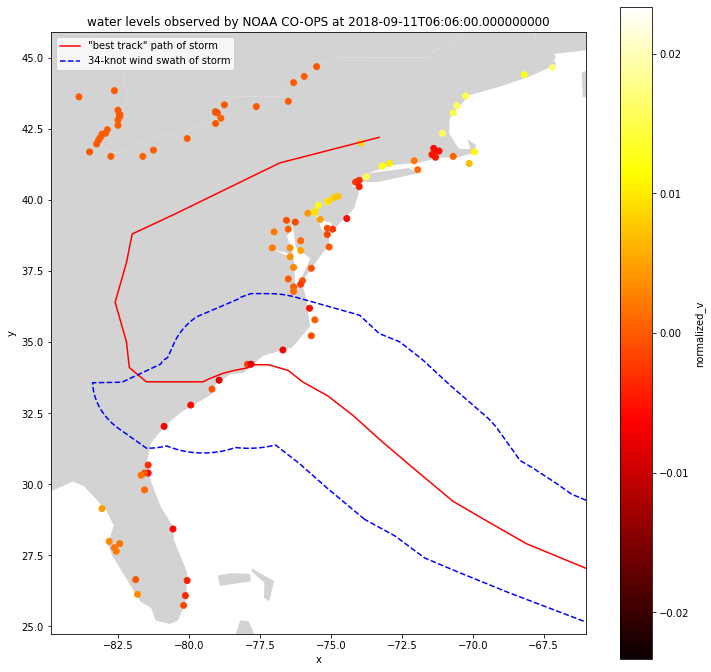

In [2962]:
figure = pyplot.figure(figsize=(12, 12))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

observed_water_levels_at_selected_time = observed_water_levels.isel(time=0)
observed_water_levels_at_selected_time.plot.scatter(x='x', y='y', hue='normalized_v', cmap='hot', ax=axis)

axis.set_title(f'water levels observed by NOAA CO-OPS at {observed_water_levels_at_selected_time["time"].values}')
axis.legend()

Text(0.5, 1.0, 'water levels observed by NOAA CO-OPS at 111 stations')

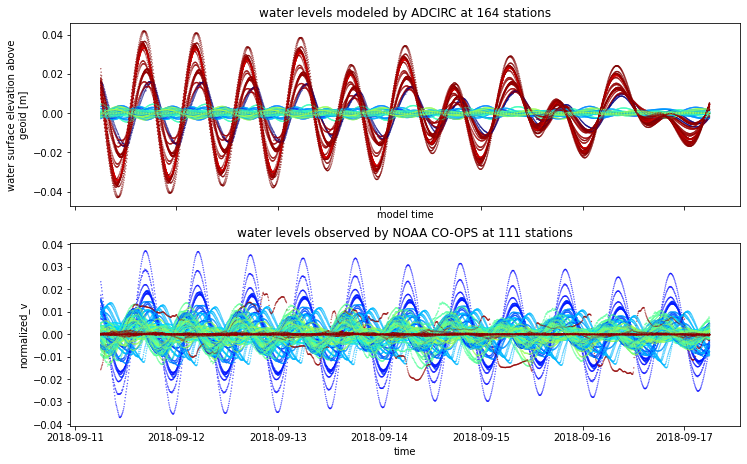

In [2963]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis_1, axis_2 = figure.subplots(2, 1, sharex='all')

modeled_water_levels.plot.scatter(x='time', y='zeta', hue='nos_id', cmap='jet', add_guide=False, s=0.1, ax=axis_1)
observed_water_levels.plot.scatter(x='time', y='normalized_v', hue='nos_id', cmap='jet', add_guide=False, s=0.1, ax=axis_2)

axis_1.set_title(f'water levels modeled by ADCIRC at {len(modeled_water_levels["nos_id"])} stations')
axis_2.set_title(f'water levels observed by NOAA CO-OPS at {len(observed_water_levels["nos_id"])} stations')

## calculate RMSE

In [2964]:
from matplotlib.cm import ScalarMappable, get_cmap
from matplotlib.colors import Normalize
from shapely.geometry import Polygon, MultiPoint

In [2965]:
rmse = ((modeled_water_levels['zeta'] - observed_water_levels['normalized_v']) ** 2).mean(dim='time') ** 0.5
rmse = rmse.assign_coords({'x': modeled_water_levels['x'], 'y': modeled_water_levels['y']})
rmse

<xarray.DataArray (nos_id: 111)>
array([0.00812301, 0.0082316 ,        nan,        nan,        nan,
              nan,        nan,        nan, 0.01146401, 0.00534835,
              nan,        nan, 0.00382725, 0.00411503,        nan,
       0.00481909, 0.00387329, 0.00221199,        nan, 0.00779452,
       0.00408149, 0.00911724, 0.0055307 ,        nan, 0.00588406,
              nan,        nan, 0.00459068,        nan, 0.00730655,
       0.0067749 , 0.00700547, 0.00688951, 0.00707517,        nan,
              nan,        nan, 0.00463058,        nan,        nan,
       0.00220683,        nan,        nan, 0.00189445, 0.00127126,
              nan,        nan, 0.00504715,        nan, 0.00309756,
              nan,        nan, 0.00256312, 0.00242339,        nan,
       0.00349018,        nan,        nan, 0.00238842,        nan,
       0.00591529,        nan, 0.00686308, 0.00468935, 0.00693863,
              nan, 0.00698584,        nan,        nan, 0.00224177,
              nan,        nan, 0.00308989, 0.00344044,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.01669584, 0.01689529, 0.01685899,
       0.01689731, 0.0169243 , 0.01691696, 0.01749603, 0.01793502,
       0.01786649, 0.01782234, 0.01753038, 0.00825563, 0.00730455,
       0.00891012, 0.01121045, 0.01680871, 0.01124193, 0.01125253,
       0.01053653, 0.01052025, 0.01049492, 0.0127035 , 0.01344044,
       0.0163808 , 0.01844508, 0.01799165, 0.01723463, 0.01832917,
       0.02122448])
Coordinates:
  * nos_id   (nos_id) int64 8311030 8311062 8410140 ... 9075002 9075014 9075035
    nws_id   (nos_id) object 'OBGN6' 'ALXN6' 'PSBM1' ... 'LKPM4' 'HRBM4' 'ESVM4'
    y        (nos_id) float64 44.69 44.34 44.91 44.66 ... 43.16 43.84 43.62
    x        (nos_id) float64 -75.5 -75.94 -67.0 -67.19 ... -82.5 -82.62 -83.88

In [2966]:
rmse_dataframe = rmse.to_dataframe(name='rmse')
rmse_dataframe = GeoDataFrame(rmse_dataframe, geometry=geopandas.points_from_xy(rmse_dataframe['x'], rmse_dataframe['y']))
rmse_dataframe = rmse_dataframe[~pandas.isna(rmse_dataframe['rmse'])]

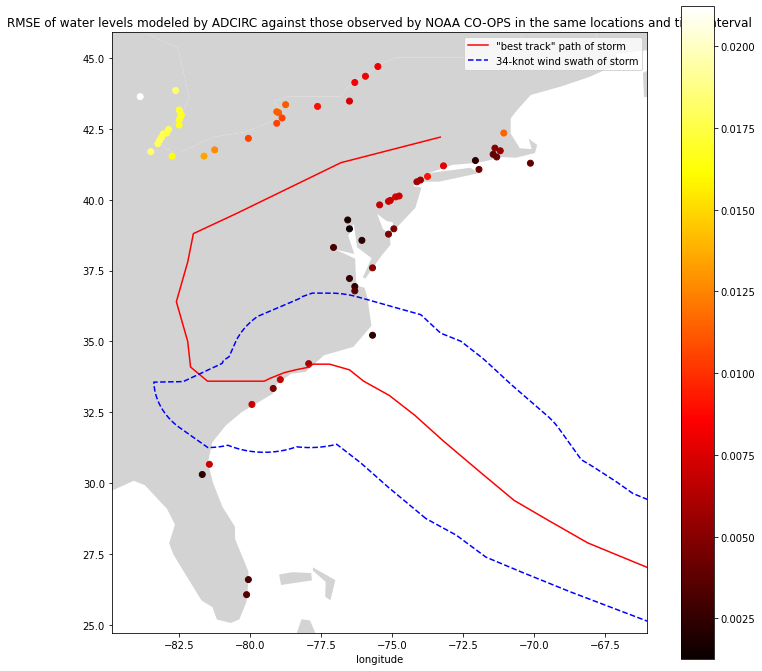

In [2967]:
figure = pyplot.figure(figsize=(12, 12))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

rmse_dataframe.plot(column='rmse', cmap='hot', ax=axis)

pyplot.colorbar(
    ScalarMappable(norm=Normalize(
        vmin=rmse_dataframe['rmse'].min(),
        vmax=rmse_dataframe['rmse'].max()),
        cmap=get_cmap('hot'),
    ),
    ax=axis,
)

axis.set_title(f'RMSE of water levels modeled by ADCIRC against those observed by NOAA CO-OPS in the same locations and time interval')
axis.legend()

### sort by distance to the track

In [2968]:
track_linestring = best_track.linestrings['BEST']['20180830T060000']
rmse_dataframe['distance_to_track'] = rmse_dataframe.geometry.distance(track_linestring)
rmse_dataframe['distance_to_track']

nos_id
8311030    2.957016
8311062    2.733052
8443970    2.242113
8447386    2.166624
8449130    3.305257
             ...   
9063085    3.253868
9063090    3.400075
9075002    4.159003
9075014    4.834865
9075035    5.165244
Name: distance_to_track, Length: 67, dtype: float64

In [2969]:
rmse_dataframe.sort_values('distance_to_track', inplace=True)

Text(0.5, 1.0, 'RMSE per station, sorted by distance to the track')

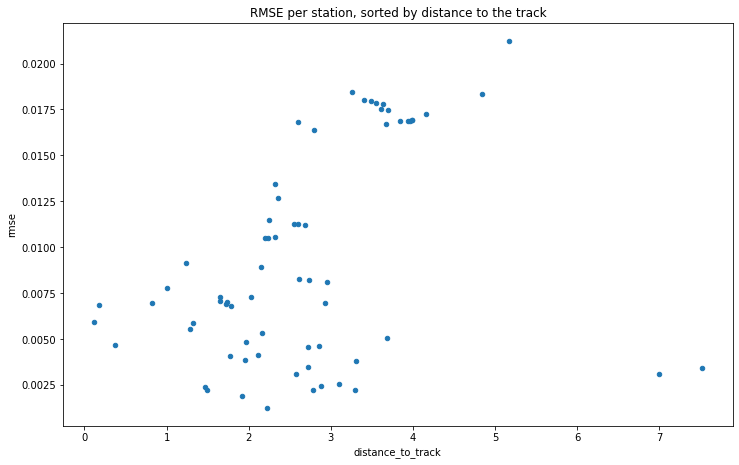

In [2970]:
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1)

rmse_dataframe.plot.scatter(x='distance_to_track', y='rmse', ax=axis)

axis.set_title('RMSE per station, sorted by distance to the track')

## calculate spatial auto-correlation of the RMSE values

### build Voronoi regions from points

In [2971]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [2972]:
voronoi_regions = Voronoi(rmse_dataframe[['x', 'y']].values)

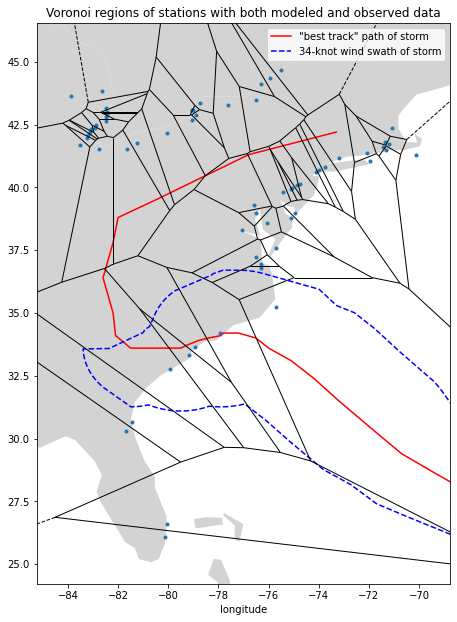

In [2973]:
figure = pyplot.figure(figsize=(12 / 1.61803398875, 12))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

voronoi_plot_2d(
    voronoi_regions,
    color='darkgrey',
    show_points=True,
    show_vertices=False,
    ax=axis,
)

axis.set_title('Voronoi regions of stations with both modeled and observed data')
axis.legend()

### attach these voronoi regions to the RMSE dataset so that we can weight them as neighbors

In [2974]:
polygons = {}
for region_index, region in enumerate(voronoi_regions.regions):
    if region_index in voronoi_regions.point_region:
        point_indices = voronoi_regions.point_region[voronoi_regions.point_region == region_index]
        points = voronoi_regions.points[[index for index in point_indices if index != -1]]
        point = points[0, :]
        entry = rmse.where(
            (rmse['x'] == point[0]) &
            (rmse['y'] == point[1]),
            drop=True,
        )
        polygon = Polygon([voronoi_regions.vertices[vertex_index] for vertex_index in region if vertex_index != -1])
        polygons[int(entry['nos_id'][0].values)] = polygon
polygons = GeoSeries(polygons)
polygons

8658120    POLYGON ((-84.515 26.864, -49.694 16.952, -65....
8661070    POLYGON ((-86.016 35.516, -77.767 29.650, -79....
8662245    POLYGON ((-77.767 29.650, -76.991 29.634, -75....
8665530    POLYGON ((-88.197 35.107, -283.365 4.009, -84....
8467150    POLYGON ((-77.479 32.233, -75.526 29.444, -76....
                                 ...                        
9014096    POLYGON ((-75.080 41.178, -73.616 39.348, -74....
9075002    POLYGON ((-75.996 41.633, -76.736 41.418, -77....
9075014    POLYGON ((-75.080 41.178, -73.616 39.348, -73....
9075035    POLYGON ((-75.938 41.516, -75.107 39.439, -74....
8722670    POLYGON ((-75.938 41.516, -75.107 39.439, -75....
Length: 63, dtype: geometry

In [2975]:
rmse_dataframe['region'] = polygons
rmse_dataframe

,nws_id,y,x,rmse,geometry,distance_to_track,region
nos_id,,,,,,,
8658120,WLON7,34.218750,-77.9375,0.005915,POINT (-77.93750 34.21875),0.110485,"POLYGON ((-84.515 26.864, -49.694 16.952, -65...."
8661070,MROS1,33.656250,-78.9375,0.006863,POINT (-78.93750 33.65625),0.175250,"POLYGON ((-86.016 35.516, -77.767 29.650, -79...."
8662245,NITS1,33.343750,-79.1875,0.004689,POINT (-79.18750 33.34375),0.368951,"POLYGON ((-77.767 29.650, -76.991 29.634, -75...."
8665530,CHTS1,32.781250,-79.9375,0.006939,POINT (-79.93750 32.78125),0.818750,"POLYGON ((-88.197 35.107, -283.365 4.009, -84...."
8467150,BRHC3,41.187500,-73.1875,0.007795,POINT (-73.18750 41.18750),1.008616,"POLYGON ((-77.479 32.233, -75.526 29.444, -76...."
...,...,...,...,...,...,...,...
9075002,LKPM4,43.156250,-82.5000,0.017235,POINT (-82.50000 43.15625),4.159003,"POLYGON ((-75.996 41.633, -76.736 41.418, -77...."
9075014,HRBM4,43.843750,-82.6250,0.018329,POINT (-82.62500 43.84375),4.834865,"POLYGON ((-75.080 41.178, -73.616 39.348, -73...."
9075035,ESVM4,43.625000,-83.8750,0.021224,POINT (-83.87500 43.62500),5.165244,"POLYGON ((-75.938 41.516, -75.107 39.439, -74...."


In [2976]:
rmse_dataframe['point'] = rmse_dataframe['geometry']
rmse_dataframe

,nws_id,y,x,rmse,geometry,distance_to_track,region,point
nos_id,,,,,,,,
8658120,WLON7,34.218750,-77.9375,0.005915,POINT (-77.93750 34.21875),0.110485,"POLYGON ((-84.515 26.864, -49.694 16.952, -65....",POINT (-77.93750 34.21875)
8661070,MROS1,33.656250,-78.9375,0.006863,POINT (-78.93750 33.65625),0.175250,"POLYGON ((-86.016 35.516, -77.767 29.650, -79....",POINT (-78.93750 33.65625)
8662245,NITS1,33.343750,-79.1875,0.004689,POINT (-79.18750 33.34375),0.368951,"POLYGON ((-77.767 29.650, -76.991 29.634, -75....",POINT (-79.18750 33.34375)
8665530,CHTS1,32.781250,-79.9375,0.006939,POINT (-79.93750 32.78125),0.818750,"POLYGON ((-88.197 35.107, -283.365 4.009, -84....",POINT (-79.93750 32.78125)
8467150,BRHC3,41.187500,-73.1875,0.007795,POINT (-73.18750 41.18750),1.008616,"POLYGON ((-77.479 32.233, -75.526 29.444, -76....",POINT (-73.18750 41.18750)
...,...,...,...,...,...,...,...,...
9075002,LKPM4,43.156250,-82.5000,0.017235,POINT (-82.50000 43.15625),4.159003,"POLYGON ((-75.996 41.633, -76.736 41.418, -77....",POINT (-82.50000 43.15625)
9075014,HRBM4,43.843750,-82.6250,0.018329,POINT (-82.62500 43.84375),4.834865,"POLYGON ((-75.080 41.178, -73.616 39.348, -73....",POINT (-82.62500 43.84375)
9075035,ESVM4,43.625000,-83.8750,0.021224,POINT (-83.87500 43.62500),5.165244,"POLYGON ((-75.938 41.516, -75.107 39.439, -74....",POINT (-83.87500 43.62500)


In [2977]:
rmse_dataframe = GeoDataFrame(
    rmse_dataframe,
    geometry=rmse_dataframe['region'],
)
rmse_dataframe

,nws_id,y,x,rmse,geometry,distance_to_track,region,point
nos_id,,,,,,,,
8658120,WLON7,34.218750,-77.9375,0.005915,"POLYGON ((-84.515 26.864, -49.694 16.952, -65....",0.110485,"POLYGON ((-84.515 26.864, -49.694 16.952, -65....",POINT (-77.93750 34.21875)
8661070,MROS1,33.656250,-78.9375,0.006863,"POLYGON ((-86.016 35.516, -77.767 29.650, -79....",0.175250,"POLYGON ((-86.016 35.516, -77.767 29.650, -79....",POINT (-78.93750 33.65625)
8662245,NITS1,33.343750,-79.1875,0.004689,"POLYGON ((-77.767 29.650, -76.991 29.634, -75....",0.368951,"POLYGON ((-77.767 29.650, -76.991 29.634, -75....",POINT (-79.18750 33.34375)
8665530,CHTS1,32.781250,-79.9375,0.006939,"POLYGON ((-88.197 35.107, -283.365 4.009, -84....",0.818750,"POLYGON ((-88.197 35.107, -283.365 4.009, -84....",POINT (-79.93750 32.78125)
8467150,BRHC3,41.187500,-73.1875,0.007795,"POLYGON ((-77.479 32.233, -75.526 29.444, -76....",1.008616,"POLYGON ((-77.479 32.233, -75.526 29.444, -76....",POINT (-73.18750 41.18750)
...,...,...,...,...,...,...,...,...
9075002,LKPM4,43.156250,-82.5000,0.017235,"POLYGON ((-75.996 41.633, -76.736 41.418, -77....",4.159003,"POLYGON ((-75.996 41.633, -76.736 41.418, -77....",POINT (-82.50000 43.15625)
9075014,HRBM4,43.843750,-82.6250,0.018329,"POLYGON ((-75.080 41.178, -73.616 39.348, -73....",4.834865,"POLYGON ((-75.080 41.178, -73.616 39.348, -73....",POINT (-82.62500 43.84375)
9075035,ESVM4,43.625000,-83.8750,0.021224,"POLYGON ((-75.938 41.516, -75.107 39.439, -74....",5.165244,"POLYGON ((-75.938 41.516, -75.107 39.439, -74....",POINT (-83.87500 43.62500)


In [2978]:
rmse_dataframe = rmse_dataframe.clip(
    MultiPoint(rmse_dataframe['point'].tolist()).convex_hull,
)
rmse_dataframe

,nws_id,y,x,rmse,geometry,distance_to_track,region,point
nos_id,,,,,,,,
8665530,CHTS1,32.78125,-79.9375,0.006939,"POLYGON ((-79.50609 29.06164, -80.98625 28.412...",0.818750,"POLYGON ((-88.197 35.107, -283.365 4.009, -84....",POINT (-79.93750 32.78125)
8539094,BDRN4,40.09375,-74.8750,0.007307,"POLYGON ((-83.12561 41.60645, -83.35913 40.485...",1.647649,"POLYGON ((-84.247 36.223, -86.016 35.516, -88....",POINT (-74.87500 40.09375)
8557380,LWSD1,38.78125,-75.1250,0.004631,"POLYGON ((-83.18905 43.38608, -83.27529 43.133...",2.856535,"POLYGON ((-83.275 43.133, -83.189 43.386, -283...",POINT (-75.12500 38.78125)
8661070,MROS1,33.65625,-78.9375,0.006863,"POLYGON ((-77.77294 29.65399, -77.77780 29.646...",0.175250,"POLYGON ((-86.016 35.516, -77.767 29.650, -79....",POINT (-78.93750 33.65625)
8548989,NBLP1,40.12500,-74.7500,0.007075,"POLYGON ((-81.13281 35.15625, -77.41465 30.198...",1.648513,"POLYGON ((-82.545 36.770, -81.133 35.156, -76....",POINT (-74.75000 40.12500)
...,...,...,...,...,...,...,...,...
8516945,KPTN6,40.81250,-73.7500,0.009117,"POLYGON ((-74.43265 42.87877, -74.51238 42.809...",1.231715,"POLYGON ((-75.763 43.613, -74.512 42.809, -74....",POINT (-73.75000 40.81250)
8518750,BATN6,40.68750,-74.0000,0.005531,"POLYGON ((-77.16914 44.01484, -77.45289 44.456...",1.290517,"POLYGON ((-75.763 43.613, -77.169 44.015, -78....",POINT (-74.00000 40.68750)
8720226,MSBF1,30.31250,-81.6875,0.002242,"POLYGON ((-74.43265 42.87877, -75.82368 44.649...",3.292843,"POLYGON ((-79.799 50.482, -79.333 49.356, -77....",POINT (-81.68750 30.31250)


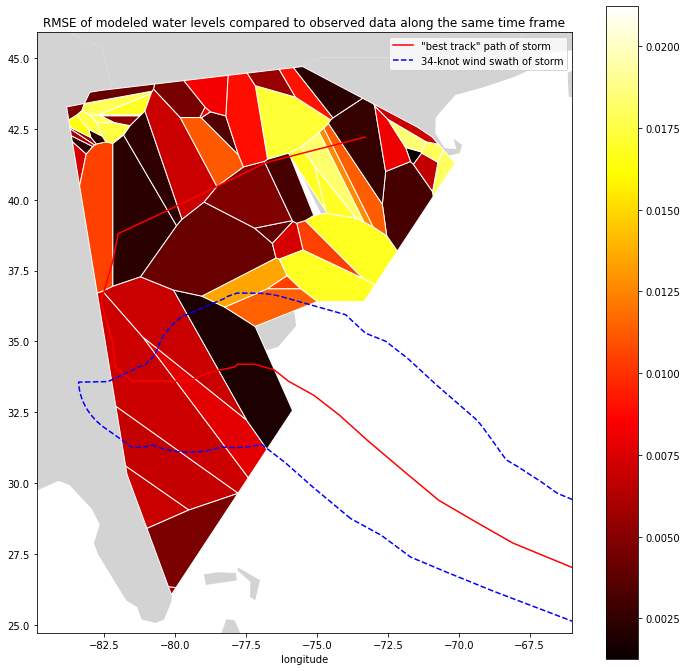

In [2979]:
figure = pyplot.figure(figsize=(12, 12))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

rmse_dataframe.plot(column='rmse', edgecolor='white', cmap='hot', ax=axis)

pyplot.colorbar(
    ScalarMappable(norm=Normalize(
        vmin=rmse_dataframe['rmse'].min(),
        vmax=rmse_dataframe['rmse'].max()),
        cmap=get_cmap('hot'),
    ),
    ax=axis,

)

axis.set_title('RMSE of modeled water levels compared to observed data along the same time frame')
axis.legend()

### univariate spatial auto-correlation

In [2980]:
from libpysal.weights import Rook
import libpysal
from esda.moran import Moran
from splot.esda import plot_moran

geopandas.options.use_pygeos = True

/home/zrb/environments/GEOG606/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


#### rook connectivity

In [2981]:
rook_weights = Rook.from_dataframe(rmse_dataframe)

In [2982]:
%%script false --no-raise-error
figure = pyplot.figure(figsize=(12, 12))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

rook_weights.plot(
    rmse_dataframe.reset_index(),
    edge_kws=dict(color='r'),
    node_kws=dict(marker=''),
    ax=axis,
)

#### spatial lag of RMSE

In [2983]:
spatial_lag = libpysal.weights.lag_spatial(rook_weights, rmse_dataframe['rmse'])

In [2984]:
rmse_dataframe['spatial_lag'] = spatial_lag

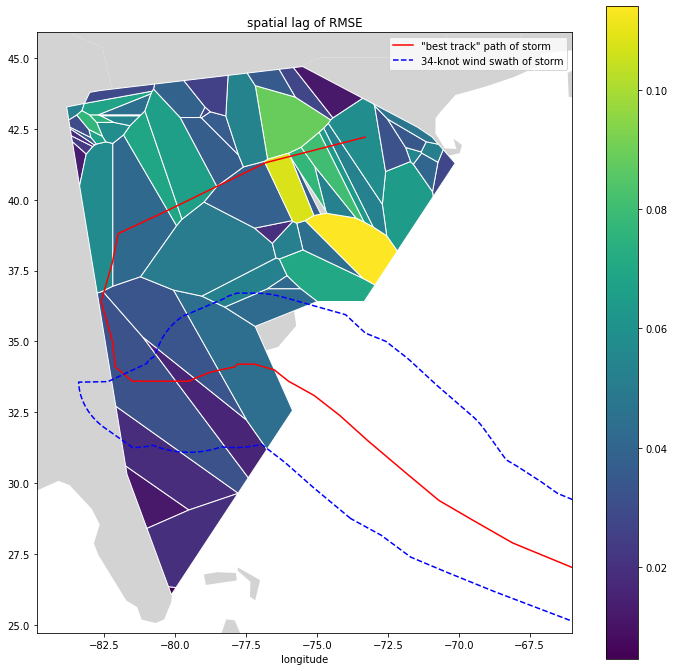

In [2985]:
figure = pyplot.figure(figsize=(12, 12))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

rmse_dataframe.plot(column='spatial_lag', edgecolor='white', cmap='viridis', ax=axis)

pyplot.colorbar(
    ScalarMappable(norm=Normalize(
        vmin=rmse_dataframe['spatial_lag'].min(),
        vmax=rmse_dataframe['spatial_lag'].max()),
        cmap=get_cmap('viridis'),
    ),
    ax=axis,

)

axis.set_title('spatial lag of RMSE')
axis.legend()

#### global Moran's I

In [2986]:
rook_morans_i = Moran(
    rmse_dataframe[['rmse']].values,
    rook_weights,
)
rook_morans_i.I

0.21664311496580688

(<Figure size 864x533.981 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.22', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.22)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

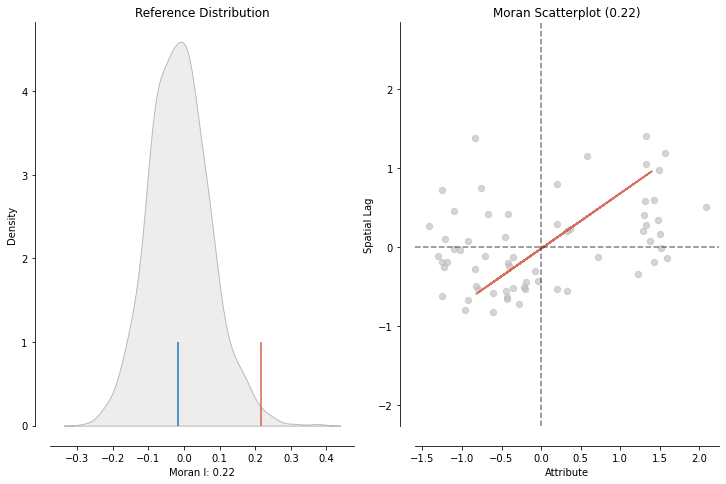

In [2987]:
plot_moran(
    rook_morans_i,
    zstandard=True,
    figsize=(12, 12 / 1.61803398875),
)

In [2988]:
rook_morans_i.p_sim

/home/zrb/environments/GEOG606/lib/python3.10/site-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


0.009

In [2989]:
rmse_dataframe['rook_morans_i_z'] = rook_morans_i.z

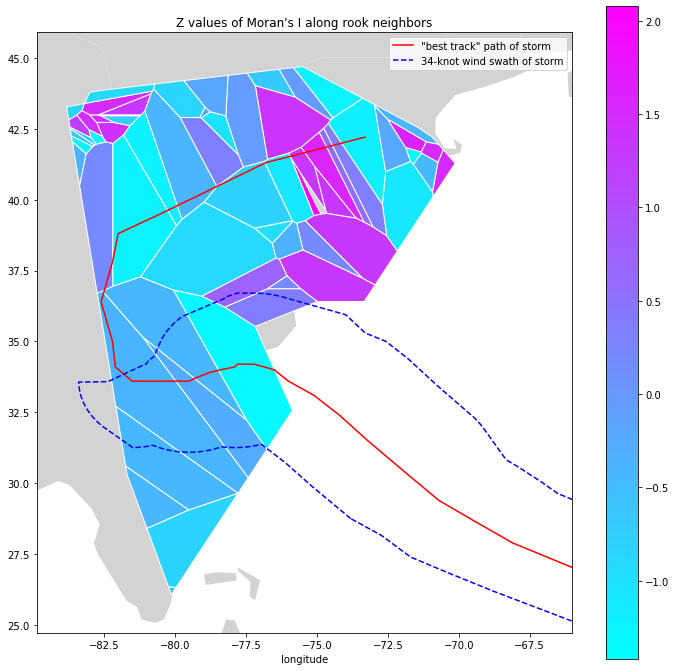

In [2990]:
figure = pyplot.figure(figsize=(12, 12))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

rmse_dataframe.plot(column='rook_morans_i_z', edgecolor='white', cmap='cool', ax=axis)

pyplot.colorbar(
    ScalarMappable(norm=Normalize(
        vmin=rmse_dataframe['rook_morans_i_z'].min(),
        vmax=rmse_dataframe['rook_morans_i_z'].max()),
        cmap=get_cmap('cool'),
    ),
    ax=axis,

)

axis.set_title('Z values of Moran\'s I along rook neighbors')
axis.legend()

#### local G

In [2991]:
from esda.getisord import G_Local

In [2992]:
local_g = G_Local(rmse_dataframe['rmse'], rook_weights, transform='B')

In [2993]:
rmse_dataframe['local_G_z'] = local_g.Zs
rmse_dataframe['local_G_z']

nos_id
8665530   -0.900222
8539094   -0.733283
8557380    2.402174
8661070   -0.971860
8548989   -0.496346
             ...   
8516945   -0.882509
8518750    0.715224
8720226   -0.913374
8311062   -1.095020
8510560    0.109993
Name: local_G_z, Length: 63, dtype: float64

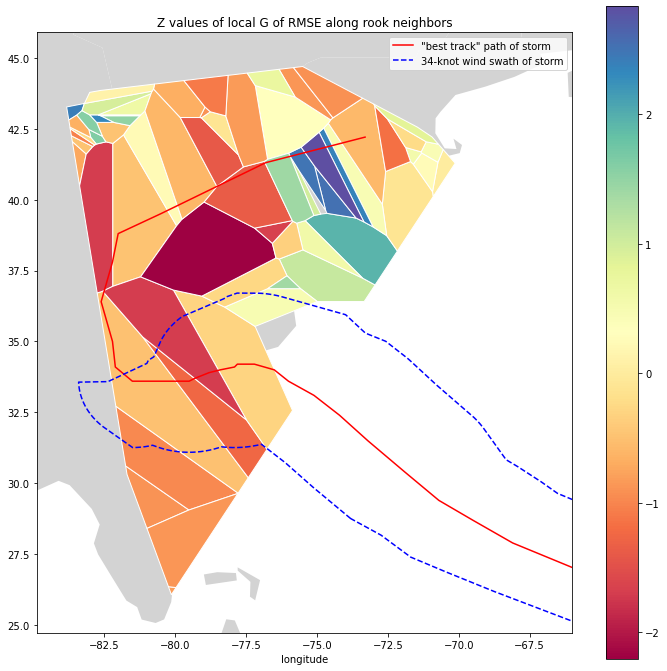

In [2994]:
figure = pyplot.figure(figsize=(12, 12))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

rmse_dataframe.plot(column='local_G_z', edgecolor='white', cmap='Spectral', ax=axis)

pyplot.colorbar(
    ScalarMappable(norm=Normalize(
        vmin=rmse_dataframe['local_G_z'].min(),
        vmax=rmse_dataframe['local_G_z'].max()),
        cmap=get_cmap('Spectral'),
    ),
    ax=axis,

)

axis.set_title('Z values of local G of RMSE along rook neighbors')
axis.legend()

#### local G*

In [2995]:
local_g_star = G_Local(rmse_dataframe['rmse'], rook_weights, transform='B', star=True)

In [2996]:
rmse_dataframe['local_G*_z'] = local_g_star.Zs
rmse_dataframe['local_G*_z']

nos_id
8665530   -0.987246
8539094   -0.812564
8557380    1.697910
8661070   -1.067742
8548989   -0.624040
             ...   
8516945   -0.820872
8518750    0.299596
8720226   -1.457043
8311062   -1.080850
8510560   -0.355292
Name: local_G*_z, Length: 63, dtype: float64

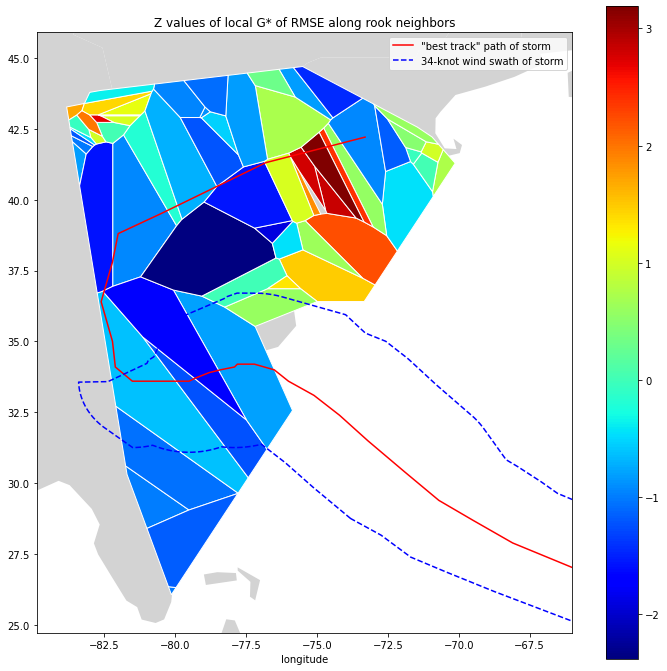

In [2997]:
figure = pyplot.figure(figsize=(12, 12))
axis = figure.add_subplot(1, 1, 1)

countries.plot(color='lightgrey', ax=axis)
best_track.data.plot.line(x='longitude', y='latitude', c='red', label='"best track" path of storm', ax=axis)
axis.plot(*wind_swath_34kt.exterior.xy, '--', c='blue', label='34-knot wind swath of storm')
axis.set_xlim(*stations_bounds[0, :])
axis.set_ylim(*stations_bounds[1, :])

rmse_dataframe.plot(column='local_G*_z', edgecolor='white', cmap='jet', ax=axis)

pyplot.colorbar(
    ScalarMappable(norm=Normalize(
        vmin=rmse_dataframe['local_G*_z'].min(),
        vmax=rmse_dataframe['local_G*_z'].max()),
        cmap=get_cmap('jet'),
    ),
    ax=axis,

)

axis.set_title('Z values of local G* of RMSE along rook neighbors')
axis.legend()